In [1]:
from pathlib import Path

from itertools import product
from cvat_sdk import Client, Config
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from skimage.measure import regionprops_table
from joblib import dump, load
from skimage import filters
from csbdeep.utils import normalize
from stardist.models import StarDist2D
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm
from skimage import exposure, feature
import scipy.ndimage as ndi

from gecs.io import loader
from gecs.settings import settings
from gecs.experiment import Axes, parse_selector, ExperimentType
from gecs.cvat.nuc_cyto import rle_to_mask
from gecs.segmentation import segment_nuclei_stardist
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

%matplotlib widget

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9)

SVM_MODEL_PATH: Path = Path("/nfs/turbo/shared/models/nuclei_survival_svm.joblib")
SVM_DATA_DIR: Path = Path("/nfs/turbo/shared/collections/nuclei_survival_svm_dataset")
NUCLEI_PROJECT_ID: int = 102
NUCLEI_LIVE_LABEL_ID: int = 112

2024-02-20 18:18:08.251786: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-20 18:18:08.253036: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 18:18:08.274595: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 18:18:08.275179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 18:18:08.634037: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
experiment = loader.load_experiment(Path("/nfs/turbo/shared/collections/nuclei_survival_svm_dataset/"), ExperimentType.CQ1)

In [3]:
client = Client(settings.cvat_url)
client.login((settings.cvat_username, settings.cvat_password))

tasks = client.projects.retrieve(NUCLEI_PROJECT_ID).get_tasks()

borders = np.zeros((experiment[Axes.Y].size, experiment[Axes.X].size), dtype=bool)
borders[:,0] = True
borders[:,-1] = True
borders[0,:]= True
borders[-1,:] = True

measurements = pd.DataFrame()
for task_meta in tqdm(tasks):
    task_name = task_meta.name
    arr = experiment.intensity.sel(parse_selector(task_name)).isel({Axes.Z: 0, Axes.TIME: 0}).load()
    anno_table = task_meta.get_annotations()

    dapi = arr.sel({Axes.CHANNEL: "DAPI"}).values
    rfp = arr.sel({Axes.CHANNEL: "RFP"}).values
    gfp = arr.sel({Axes.CHANNEL: "GFP"}).values

    smoothed_dapi = filters.gaussian(dapi, sigma=0.5)
    eqd_dapi = exposure.equalize_adapthist(smoothed_dapi, kernel_size=(10,10), clip_limit=0.03)
    filtered_dapi = ndi.maximum_filter(eqd_dapi, size=2)

    smoothed_gfp = filters.gaussian(gfp, sigma=2)
    eqd_gfp = exposure.equalize_adapthist(smoothed_gfp, kernel_size=(10,10), clip_limit=0.03)
    filtered_gfp = ndi.maximum_filter(eqd_gfp, size=2)
    
    dapi_background = np.median(dapi)
    rfp_background = np.median(rfp)
    gfp_background = np.median(gfp)

    rows = []
    for shape in anno_table.shapes:
        if shape.frame != 0:
            continue
        
        state = shape.label_id
        if state not in [112,118,117]:
            continue

        rle = list(map(int, shape.points))
        l, t, r, b = rle[-4:]
        patch_height, patch_width = (b - t + 1, r - l + 1)
        patch_mask = rle_to_mask(rle[:-4], patch_width, patch_height)

        dapi_patch = filtered_dapi[t:b+1, l:r+1]
        dapi_peaks = feature.peak_local_max(dapi_patch, min_distance=2)
        n_dapi_puncta = len([peak for peak in dapi_peaks if patch_mask[tuple(peak)]])

        gfp_patch = filtered_gfp[t:b+1, l:r+1]
        gfp_peaks = feature.peak_local_max(gfp_patch, min_distance=2)
        n_gfp_puncta = len([peak for peak in gfp_peaks if patch_mask[tuple(peak)]])
        
        mask = np.zeros((arr[Axes.Y].size, arr[Axes.X].size), dtype=bool)
        mask[t:b+1, l:r+1][patch_mask] = True
        
        if (np.logical_and(borders, mask)).any():
            continue
        
        rows.append({
            "task_name": task_name,
            "id": shape.id,
            "dead": not (state == 112),
            "dapi_mean": dapi[mask].mean(),
            "dapi_med": np.median(dapi[mask]),
            "dapi_std": dapi[mask].std(),
            "dapi_field_med": dapi_background,
            "rfp_mean": rfp[mask].mean(),
            "rfp_med": np.median(rfp[mask]),
            "rfp_std": rfp[mask].std(),
            "rfp_field_med": rfp_background,
            "gfp_mean": gfp[mask].mean(),
            "gfp_med": np.median(gfp[mask]),
            "gfp_std": gfp[mask].std(),
            "gfp_field_med": gfp_background,
            "size": mask.astype(int).sum(),
            "n_dapi_puncta": n_dapi_puncta,
            "n_gfp_puncta": n_gfp_puncta
        })
        
    df = pd.DataFrame.from_records(rows)
    measurements = pd.concat((measurements, df))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [01:55<00:00,  2.40s/it]


In [4]:
df = measurements
df["dapi_signal"] = df["dapi_med"] / df["dapi_field_med"]
df["gfp_signal"] = df["gfp_med"] / df["gfp_field_med"]
df["rfp_signal"] = df["rfp_med"] / df["rfp_field_med"]

live = df.loc[~df["dead"]]
dead = df.loc[df["dead"]]

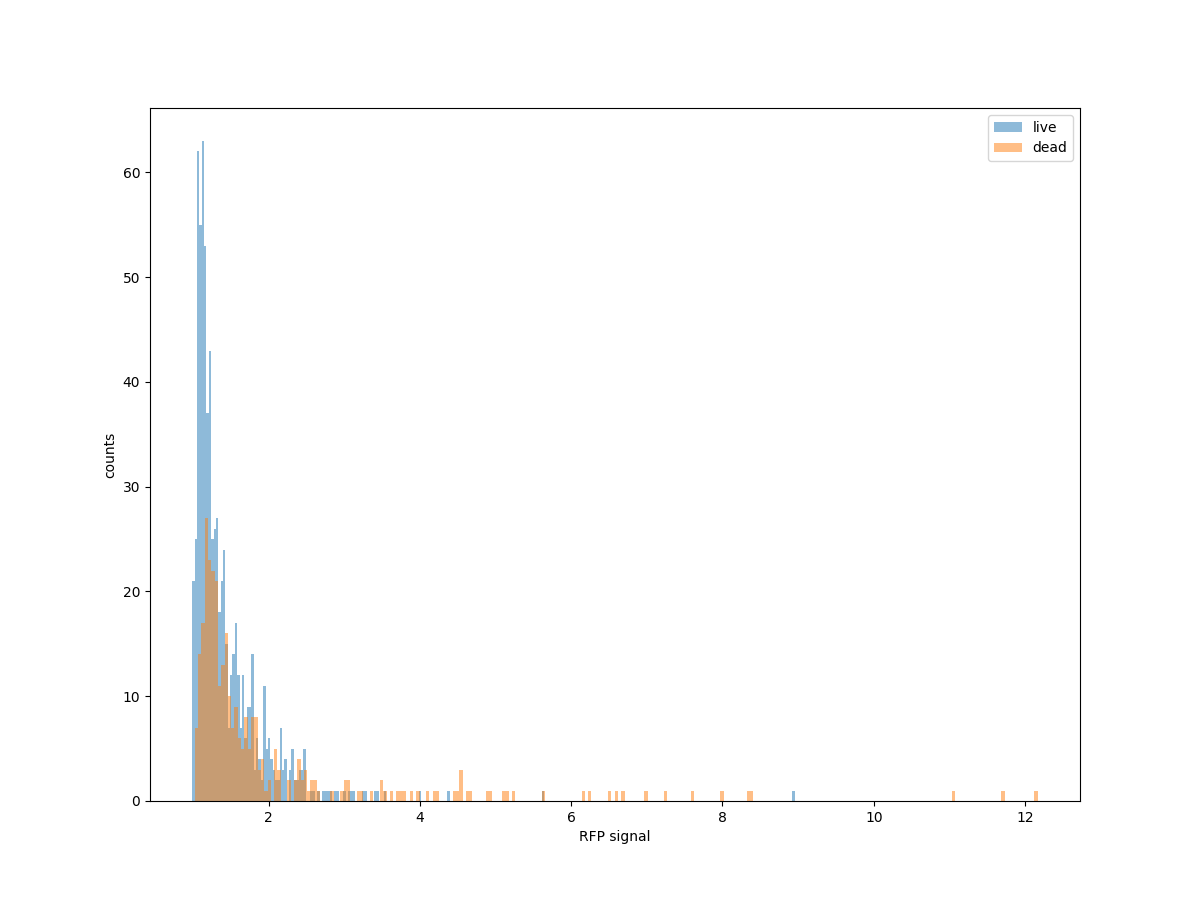

In [5]:
fig, ax = plt.subplots()
ax.hist(live["rfp_signal"], bins=255, alpha=0.5, label="live")
ax.hist(dead["rfp_signal"], bins=255, alpha=0.5, label="dead")
ax.legend()
ax.set_xlabel("RFP signal")
ax.set_ylabel("counts")
plt.show()

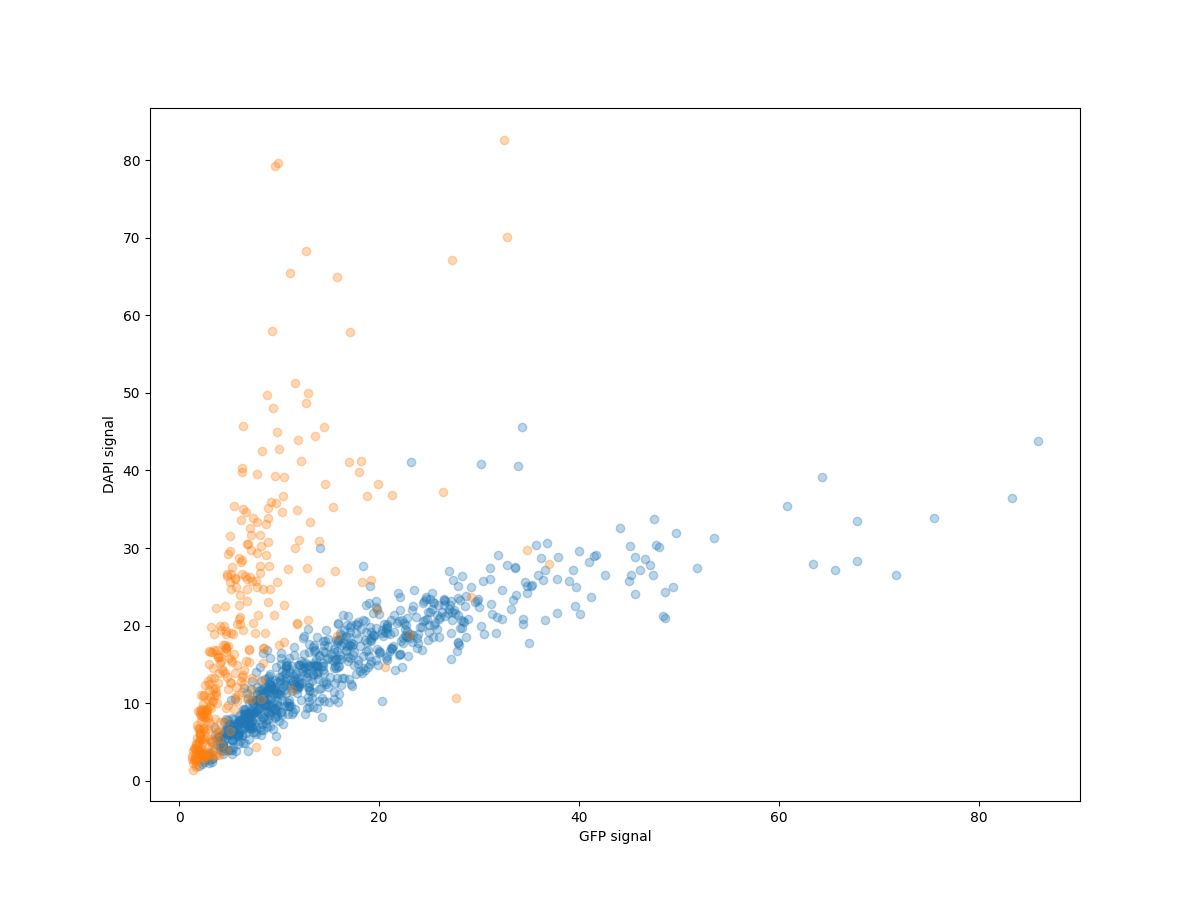

In [6]:
fig, ax = plt.subplots()
ax.scatter(live["gfp_signal"], live["dapi_signal"], alpha=0.3)
ax.scatter(dead["gfp_signal"], dead["dapi_signal"], alpha=0.3)
ax.set_xlabel("GFP signal")
ax.set_ylabel("DAPI signal")
plt.show()

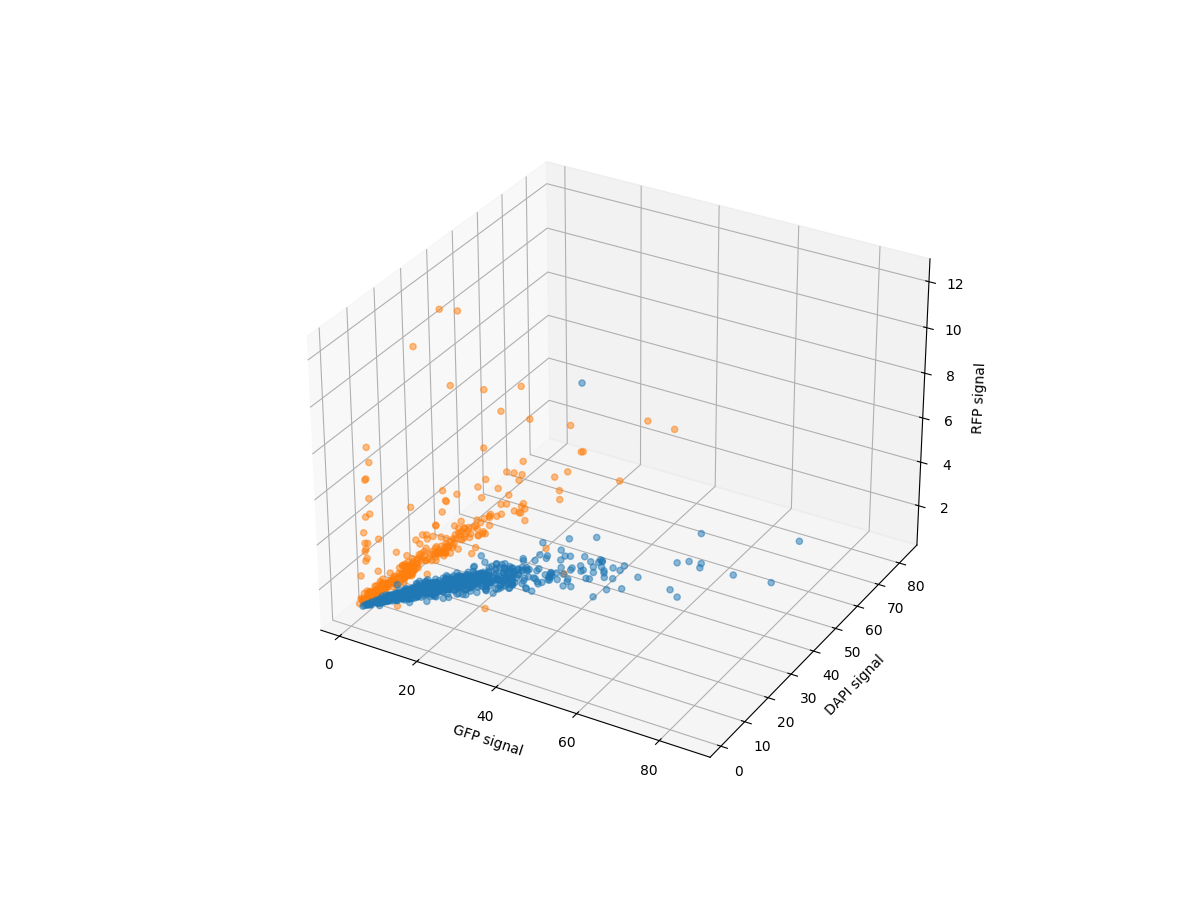

In [7]:
fig  = plt.figure()

ax = fig.add_subplot(projection="3d")

cols = ["dapi_mean","gfp_mean","rfp_mean"]

ax.scatter(live["gfp_signal"], live["dapi_signal"], live["rfp_signal"], alpha=0.5)
ax.scatter(dead["gfp_signal"], dead["dapi_signal"], dead["rfp_signal"], alpha=0.5)
ax.set_ylabel("DAPI signal")
ax.set_xlabel("GFP signal")
ax.set_zlabel("RFP signal")
plt.show()

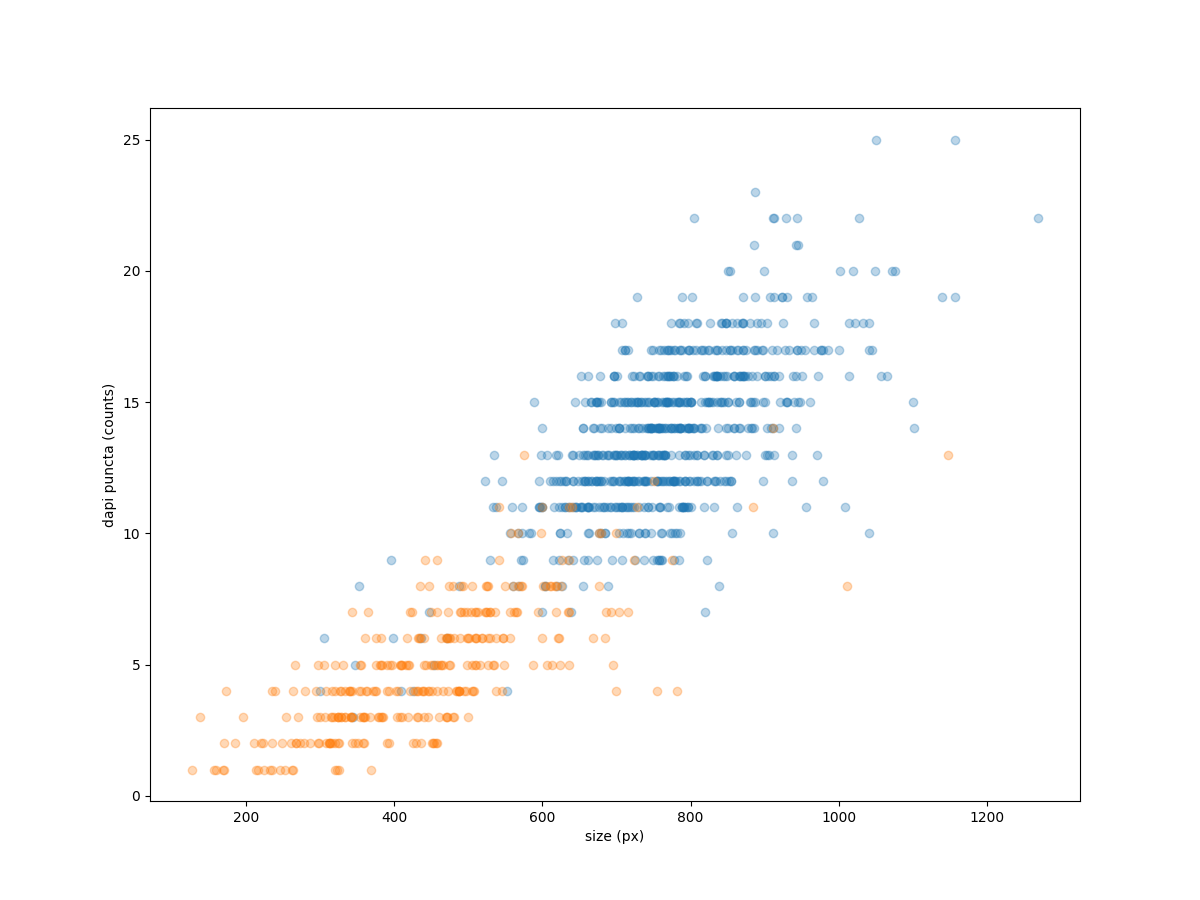

In [9]:
fig,ax = plt.subplots()
ax.scatter(live["size"], live["n_dapi_puncta"], alpha=0.3)
ax.scatter(dead["size"], dead["n_dapi_puncta"], alpha=0.3)
ax.set_xlabel("size (px)")
ax.set_ylabel("dapi puncta (counts)")
plt.show()

In [11]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
cols = ["gfp_signal", "rfp_signal", "dapi_signal", "size", "n_dapi_puncta"]
scaler = StandardScaler()
X = scaler.fit_transform(df[cols].values)
y = df["dead"].values
clf = SVC(C=10, kernel="linear")

print(cross_val_score(clf,X, y, scoring="f1_macro").mean())
df["preds"] = cross_val_predict(clf, X, y)

0.9818297364442976


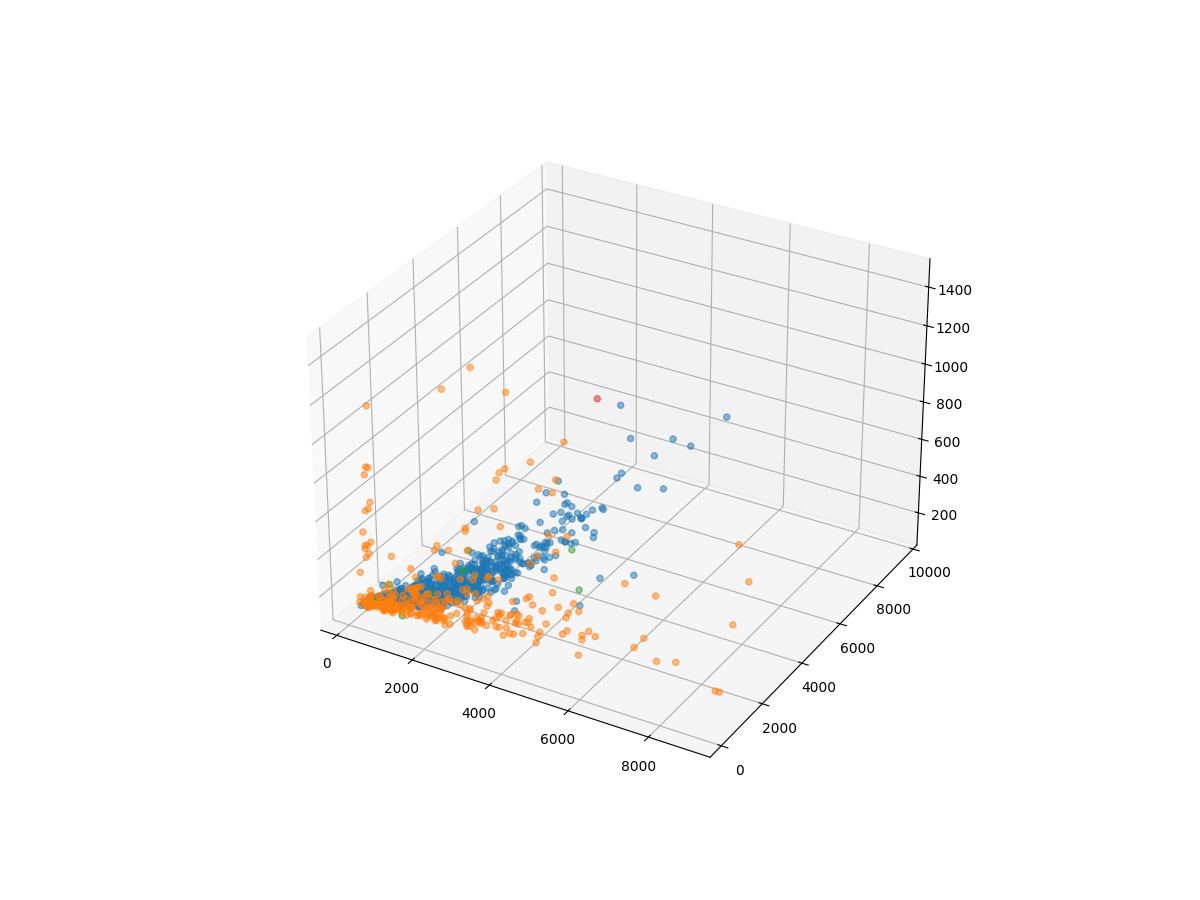

In [12]:
fig = plt.figure()
df = measurements
ax = fig.add_subplot(projection="3d")

live = df.loc[~df["dead"]]
dead = df.loc[df["dead"]]

true_live = live.loc[~live["preds"]]
true_dead = dead.loc[dead["preds"]]
false_live = dead.loc[~dead["preds"]]
false_dead = live.loc[live["preds"]]

def plot(subdf):
    ax.scatter(subdf["dapi_mean"], subdf["gfp_mean"], subdf["rfp_mean"], alpha=0.5)

plot(true_live)
plot(true_dead)
plot(false_live)
plot(false_dead)


plt.show()

In [89]:
false_dead

,task_name,id,dead,dapi_mean,dapi_med,dapi_std,dapi_field_med,rfp_mean,rfp_med,rfp_std,...,size,n_dapi_puncta,n_gfp_puntac,dapi_signal,gfp_signal,rfp_signal,n_gfp_puncta,preds,dapi_puncta_density,puncta_ratio
9,region-E10|field-9|channel-DAPI:RFP:GFP,20867,False,3205.225248,3328.0,1275.892744,111.0,139.972772,139.0,9.912326,...,404,3,5,29.981982,11.633621,1.148760,5,True,0.007426,0.60
20,region-E10|field-9|channel-DAPI:RFP:GFP,20881,False,1208.879397,1264.5,528.649128,111.0,131.912060,130.0,10.088543,...,398,6,5,11.391892,8.568966,1.074380,5,True,0.015075,1.20
12,region-E10|field-5|channel-DAPI:RFP:GFP,20723,False,4318.403670,4504.0,1379.520224,111.0,1092.788991,1083.5,106.115337,...,436,6,8,40.576577,33.932203,8.954545,8,True,0.013761,0.75
